In [1]:
# Cell 1: basic imports and notebook settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Optional: display settings for nicer tables
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

# For reproducibility of synthetic data
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
# Cell 2: define key scope variables per your requirements
REGION = 'Europe'  # region of interest
YEARS = list(range(2019, 2024))  # past 5 years: 2019,2020,2021,2022,2023
# If you want to include 2024, adjust to range(2019, 2025)

AGE_GROUPS = ['<18', '18-24', '25-34', '35-44', '45-54', '55+']
GENDERS = ['Male', 'Female', 'Other']
INCOME_BRACKETS = ['Low', 'Middle', 'High']
URBAN_RURAL = ['Urban', 'Rural']

In [3]:
# Cell 3: example list of European countries to simulate
# You can expand or reduce this list as needed.
EU_COUNTRIES = ['Italy', 'France', 'Germany', 'Spain', 'Netherlands', 
                'Belgium', 'Sweden', 'Poland', 'Portugal', 'Greece']

# Define base sales scale per country (in USD, for illustration)
# Italy for instance has a big share of Europe's ice cream market; use a higher base.
base_sales = {
    'Italy': 120,   # hypothetical base million USD in first year
    'France': 90,
    'Germany': 100,
    'Spain': 80,
    'Netherlands': 40,
    'Belgium': 35,
    'Sweden': 30,
    'Poland': 50,
    'Portugal': 25,
    'Greece': 20
}

# Hypothetical overall average profit margin (in percentage) for Cornetto in Europe
# This is synthetic; replace with real figure if available.
OVERALL_PROFIT_MARGIN = 0.18  # 18%

In [4]:
# Cell 4: function to apply yearly growth
def grow_sales(value, growth_rate):
    return value * (1 + growth_rate)

# Example: define a growth rate per year, possibly capturing pandemic effects or market momentum.
# You can adjust or load from an external file.
yearly_growth = {
    2019: 0.00,   # baseline
    2020: -0.05,  # e.g., pandemic dip
    2021: 0.10,   # recovery
    2022: 0.12,
    2023: 0.08
}

# Build a dictionary of country-year sales before demographic split
country_year_sales = []
for country, base in base_sales.items():
    value = base
    for year in YEARS:
        # Apply growth if entry exists; else assume same
        gr = yearly_growth.get(year, 0)
        value = grow_sales(value, gr)
        country_year_sales.append({
            'Country': country,
            'Year': year,
            'Sales_mUSD': value  # million USD
        })

df_country_sales = pd.DataFrame(country_year_sales)
df_country_sales.head()

,Country,Year,Sales_mUSD
0,Italy,2019,120.00000
1,Italy,2020,114.00000
2,Italy,2021,125.40000
3,Italy,2022,140.44800
4,Italy,2023,151.68384


In [5]:
# Cell 5: helper to generate proportion distribution that sums to 1
def random_proportions(categories, skew=None):
    """
    Generate a random distribution over categories summing to 1.
    'skew' can be a dict with category weights to bias distribution.
    """
    if skew:
        weights = np.array([skew.get(cat, 1.0) for cat in categories], dtype=float)
    else:
        weights = np.ones(len(categories))
    # generate random numbers then weight
    r = np.random.rand(len(categories)) * weights
    return r / r.sum()

# Example skew: maybe Italy or some countries skew to younger age groups
age_skew = {'<18': 1.2, '18-24': 1.3, '25-34': 1.1}  # optional biases
gender_skew = None
income_skew = None
urban_skew = {'Urban': 1.4, 'Rural': 0.6}

records = []
for _, row in df_country_sales.iterrows():
    country = row['Country']
    year = row['Year']
    total_sales = row['Sales_mUSD'] * 1_000_000  # convert to USD
    # Distribute across demographics
    age_props = random_proportions(AGE_GROUPS, skew=age_skew)
    gender_props = random_proportions(GENDERS, skew=gender_skew)
    income_props = random_proportions(INCOME_BRACKETS, skew=income_skew)
    urban_props = random_proportions(URBAN_RURAL, skew=urban_skew)
    
    # Create combinations
    for i, age in enumerate(AGE_GROUPS):
        for j, gender in enumerate(GENDERS):
            for k, income in enumerate(INCOME_BRACKETS):
                for l, ur in enumerate(URBAN_RURAL):
                    # Assume independence for simplicity; adjust if real data suggests correlation
                    proportion = age_props[i] * gender_props[j] * income_props[k] * urban_props[l]
                    # Normalize later or scale so total equals total_sales
                    sales = total_sales * proportion
                    # Profit margin synthetic: overall average plus small random noise
                    profit_margin = np.clip(
                        OVERALL_PROFIT_MARGIN + np.random.normal(0, 0.02),
                        0.05, 0.35  # ensure within reasonable bounds
                    )
                    profit = sales * profit_margin
                    
                    records.append({
                        'Country': country,
                        'Year': year,
                        'Age_Group': age,
                        'Gender': gender,
                        'Income_Bracket': income,
                        'Urban_Rural': ur,
                        'Sales_USD': sales,
                        'Profit_Margin': profit_margin,
                        'Profit_USD': profit
                    })

df_demo = pd.DataFrame(records)

# Quick check: ensure sums are roughly equal to country totals
summary_check = df_demo.groupby(['Country', 'Year'])['Sales_USD'].sum().reset_index()
merged = df_country_sales.merge(summary_check, on=['Country', 'Year'])
merged.head()

,Country,Year,Sales_mUSD,Sales_USD
0,Italy,2019,120.00000,120000000.0
1,Italy,2020,114.00000,114000000.0
2,Italy,2021,125.40000,125400000.0
3,Italy,2022,140.44800,140448000.0
4,Italy,2023,151.68384,151683840.0


In [7]:
# Cell 5b: optional normalization to ensure exact match to country totals

def normalize_country_year(group):
    country, year = group.name  # group.name is (Country, Year)

    target_row = df_country_sales.loc[
        (df_country_sales["Country"] == country) &
        (df_country_sales["Year"] == year),
        "Sales_mUSD"
    ]

    # If no target exists for this (country, year), leave group unchanged
    if target_row.empty:
        return group

    target = target_row.iloc[0] * 1_000_000  # convert mUSD -> USD
    current_total = group["Sales_USD"].sum()

    if current_total > 0:
        scale = target / current_total
        group = group.copy()
        group["Sales_USD"] = group["Sales_USD"] * scale
        group["Profit_USD"] = group["Profit_USD"] * scale

    return group

df_demo = (
    df_demo
    .groupby(["Country", "Year"], group_keys=False)
    .apply(normalize_country_year, include_groups=False)
)

In [10]:
df_demo.columns

Index(['index', 'Age_Group', 'Gender', 'Income_Bracket', 'Urban_Rural', 'Sales_USD', 'Profit_Margin', 'Profit_USD'], dtype='object')

   Year     Sales_USD    Profit_USD  Profit_Margin
0  2018  7.621781e+07  1.849098e+07       0.242607
1  2019  5.406585e+07  1.243117e+07       0.229926
2  2020  1.082710e+08  1.427562e+07       0.131851
3  2021  8.023615e+07  1.152868e+07       0.143684
4  2022  8.192490e+07  1.784131e+07       0.217776
5  2023  9.252814e+07  1.161956e+07       0.125579


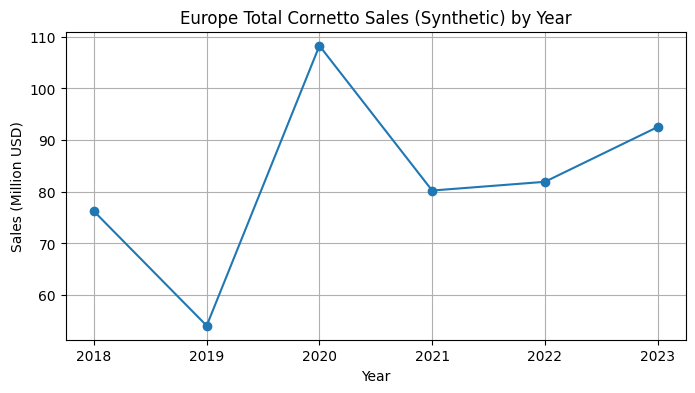

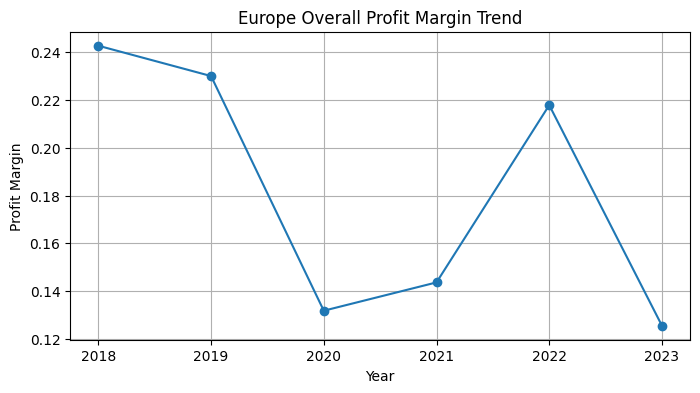

In [13]:
# ===============================
# Imports
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# Create synthetic dataset
# ===============================
np.random.seed(42)

years = np.arange(2018, 2024)
regions = ['Europe', 'North America', 'Asia']

data = []

for year in years:
    for region in regions:
        sales = np.random.uniform(50_000_000, 120_000_000)
        profit = sales * np.random.uniform(0.1, 0.25)
        
        data.append([year, region, sales, profit])

df = pd.DataFrame(data, columns=[
    'Year', 'Region', 'Sales_USD', 'Profit_USD'
])

# ===============================
# Filter Europe
# ===============================
europe_summary = df[df['Region'] == 'Europe']

# ===============================
# Total Europe sales each year
# ===============================
total_by_year = europe_summary.groupby('Year').agg({
    'Sales_USD': 'sum',
    'Profit_USD': 'sum'
}).reset_index()

# Profit margin
total_by_year['Profit_Margin'] = (
    total_by_year['Profit_USD'] / total_by_year['Sales_USD']
)

print(total_by_year)

# ===============================
# Plot sales trend
# ===============================
plt.figure(figsize=(8, 4))
plt.plot(total_by_year['Year'],
         total_by_year['Sales_USD'] / 1e6,
         marker='o')

plt.title('Europe Total Cornetto Sales (Synthetic) by Year')
plt.ylabel('Sales (Million USD)')
plt.xlabel('Year')
plt.grid(True)
plt.show()

# ===============================
# Plot profit margin trend
# ===============================
plt.figure(figsize=(8, 4))
plt.plot(total_by_year['Year'],
         total_by_year['Profit_Margin'],
         marker='o')

plt.title('Europe Overall Profit Margin Trend')
plt.ylabel('Profit Margin')
plt.xlabel('Year')
plt.grid(True)
plt.show()

In [17]:
print(europe_summary.columns.tolist())

['Year', 'Region', 'Sales_USD', 'Profit_USD']


In [18]:
[c for c in europe_summary.columns if 'age' in c.lower()]

[]

In [19]:
# Cell 8: save to CSV or Excel for further use
df_demo.to_csv('cornetto_europe_demographics_sales.csv', index=False)
europe_summary.to_csv('cornetto_europe_summary.csv', index=False)

# Optional Excel
with pd.ExcelWriter('cornetto_europe_data.xlsx') as writer:
    df_demo.to_excel(writer, sheet_name='Detailed', index=False)
    europe_summary.to_excel(writer, sheet_name='Summary', index=False)

In [20]:
# Cell 9: load real data example
# Modify file paths and columns to match real files
try:
    real_df = pd.read_csv('real_cornetto_sales.csv')  # expected columns e.g. Year, Country, Age_Group, ...
    # Example check
    print(real_df.head())
except FileNotFoundError:
    print("Real data file not found; using synthetic dataset.")

Real data file not found; using synthetic dataset.
